In [ ]:
import os
import numpy as np
import pandas as pd

from utils import *
from osgeo import gdal
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates

plt.rcParams['font.family'] = ['Arial', 'SimSun']
# plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['axes.formatter.useoffset'] = False

In [9]:
province = 'ZJ'
directory = os.path.join('.\\TimeSeriesImages\\SA_blocks_clipped&mosaic', province)
sorted_date = sorted(os.listdir(directory), \
                    key=lambda x: pd.to_datetime(x.split('.')[0], format='%Y_%m'))
sorted_date = sorted_date[5:]
imgs = [os.path.join(directory, date) for date in sorted_date] # imgs: Time Series Images
print(sorted_date)

['2020_01.tif', '2020_02.tif', '2020_03.tif', '2020_04.tif', '2020_05.tif', '2020_06.tif', '2020_07.tif', '2020_08.tif', '2020_09.tif', '2020_10.tif', '2020_11.tif', '2020_12.tif', '2021_01.tif', '2021_02.tif', '2021_03.tif', '2021_04.tif', '2021_05.tif', '2021_06.tif', '2021_07.tif', '2021_08.tif', '2021_09.tif', '2021_10.tif', '2021_11.tif', '2021_12.tif', '2022_01.tif', '2022_02.tif', '2022_03.tif', '2022_04.tif', '2022_05.tif', '2022_06.tif', '2022_07.tif', '2022_08.tif', '2022_09.tif', '2022_10.tif', '2022_11.tif', '2022_12.tif', '2023_01.tif', '2023_02.tif', '2023_03.tif', '2023_04.tif', '2023_05.tif', '2023_06.tif', '2023_07.tif', '2023_08.tif', '2023_09.tif', '2023_10.tif', '2023_11.tif', '2023_12.tif', '2024_01.tif', '2024_02.tif', '2024_03.tif', '2024_04.tif', '2024_05.tif', '2024_06.tif', '2024_07.tif', '2024_08.tif', '2024_09.tif', '2024_10.tif', '2024_11.tif', '2024_12.tif']


In [10]:
# Extract time series data at a given location
def extract_time_series_data(lat_lon, img_path):
    lat, lon = lat_lon[1], lat_lon[0]
    data = gdal.Open(img_path)
    # get geo transform
    transform = data.GetGeoTransform()
    x, y = int((lon - transform[0]) / transform[1]), int((lat - transform[3]) / transform[5])
    pixel_values = data.ReadAsArray(x, y, 1, 1)
    del data
    return pixel_values.flatten()

In [11]:
sa, bf, water, herbicide = '#00A664', '#EEC186', '#1999B2', '#95BCE5'
# lat_lon, change_date, color, event = [121.80698, 31.63544], \
#                               [pd.to_datetime(date) for date in ['2020-05', '2023-9-15']], \
#                               [bf, sa, herbicide], \
#                               ['入侵', '化学施药'] # Herbicide / SH_1 / SH_2_218:15
lat_lon, change_date, color, event = [121.24982, 30.3923], \
                              [pd.to_datetime(date) for date in ['2023-07-15', '2024-04-15']], \
                              [sa, bf, water], \
                              ['刈割', '围淹']
# lat_lon, change_date, color, event = [119.267538, 37.84661], \
#                               [pd.to_datetime(date) for date in ['2020-06', '2021-10-15', '2022-02', '2022-08-15']], \
#                               [bf, sa, bf, sa, bf], \
#                               ['入侵', '刈割', '复发', '刈割'] # SD_1_312:50 / SD_2
# lat_lon, change_date, color, event = [121.77503, 29.52624], \
#                               [pd.to_datetime(date) for date in ['2023-04-15']], \
#                               [sa, bf], \
#                               ['刈割'] # SD_1_312:50 / SD_2

cls_path = '.\\TimeSeriesImages\\result\\classification.tif'
'''
    imgs:           Time Series Images
    dfs_latlon:     Samples' latitude and longitude List
    cls:            Classification Result
'''
# ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'VV', 'VH']
pixel_ts_value = [extract_time_series_data(lat_lon, img) for img in imgs]
pixel_ts_value = np.stack(pixel_ts_value, axis=0) # 60 × 12
# Time Series
ngb_ts, v3h_ts = pixel_ts_value[:, list([6, 2, 1])], pixel_ts_value[:, list([10, 11])]    # NIR R G B, VV VH
dates = pd.date_range(start='2020-01-01', end='2024-12-01', freq='MS') # Dates
ndvi = (ngb_ts[:, 0] - ngb_ts[:, 1]) / (ngb_ts[:, 0] + ngb_ts[:, 1] + 1e-6)  # NDVI
change_date = [dates[0]] + change_date + [dates[-1]]

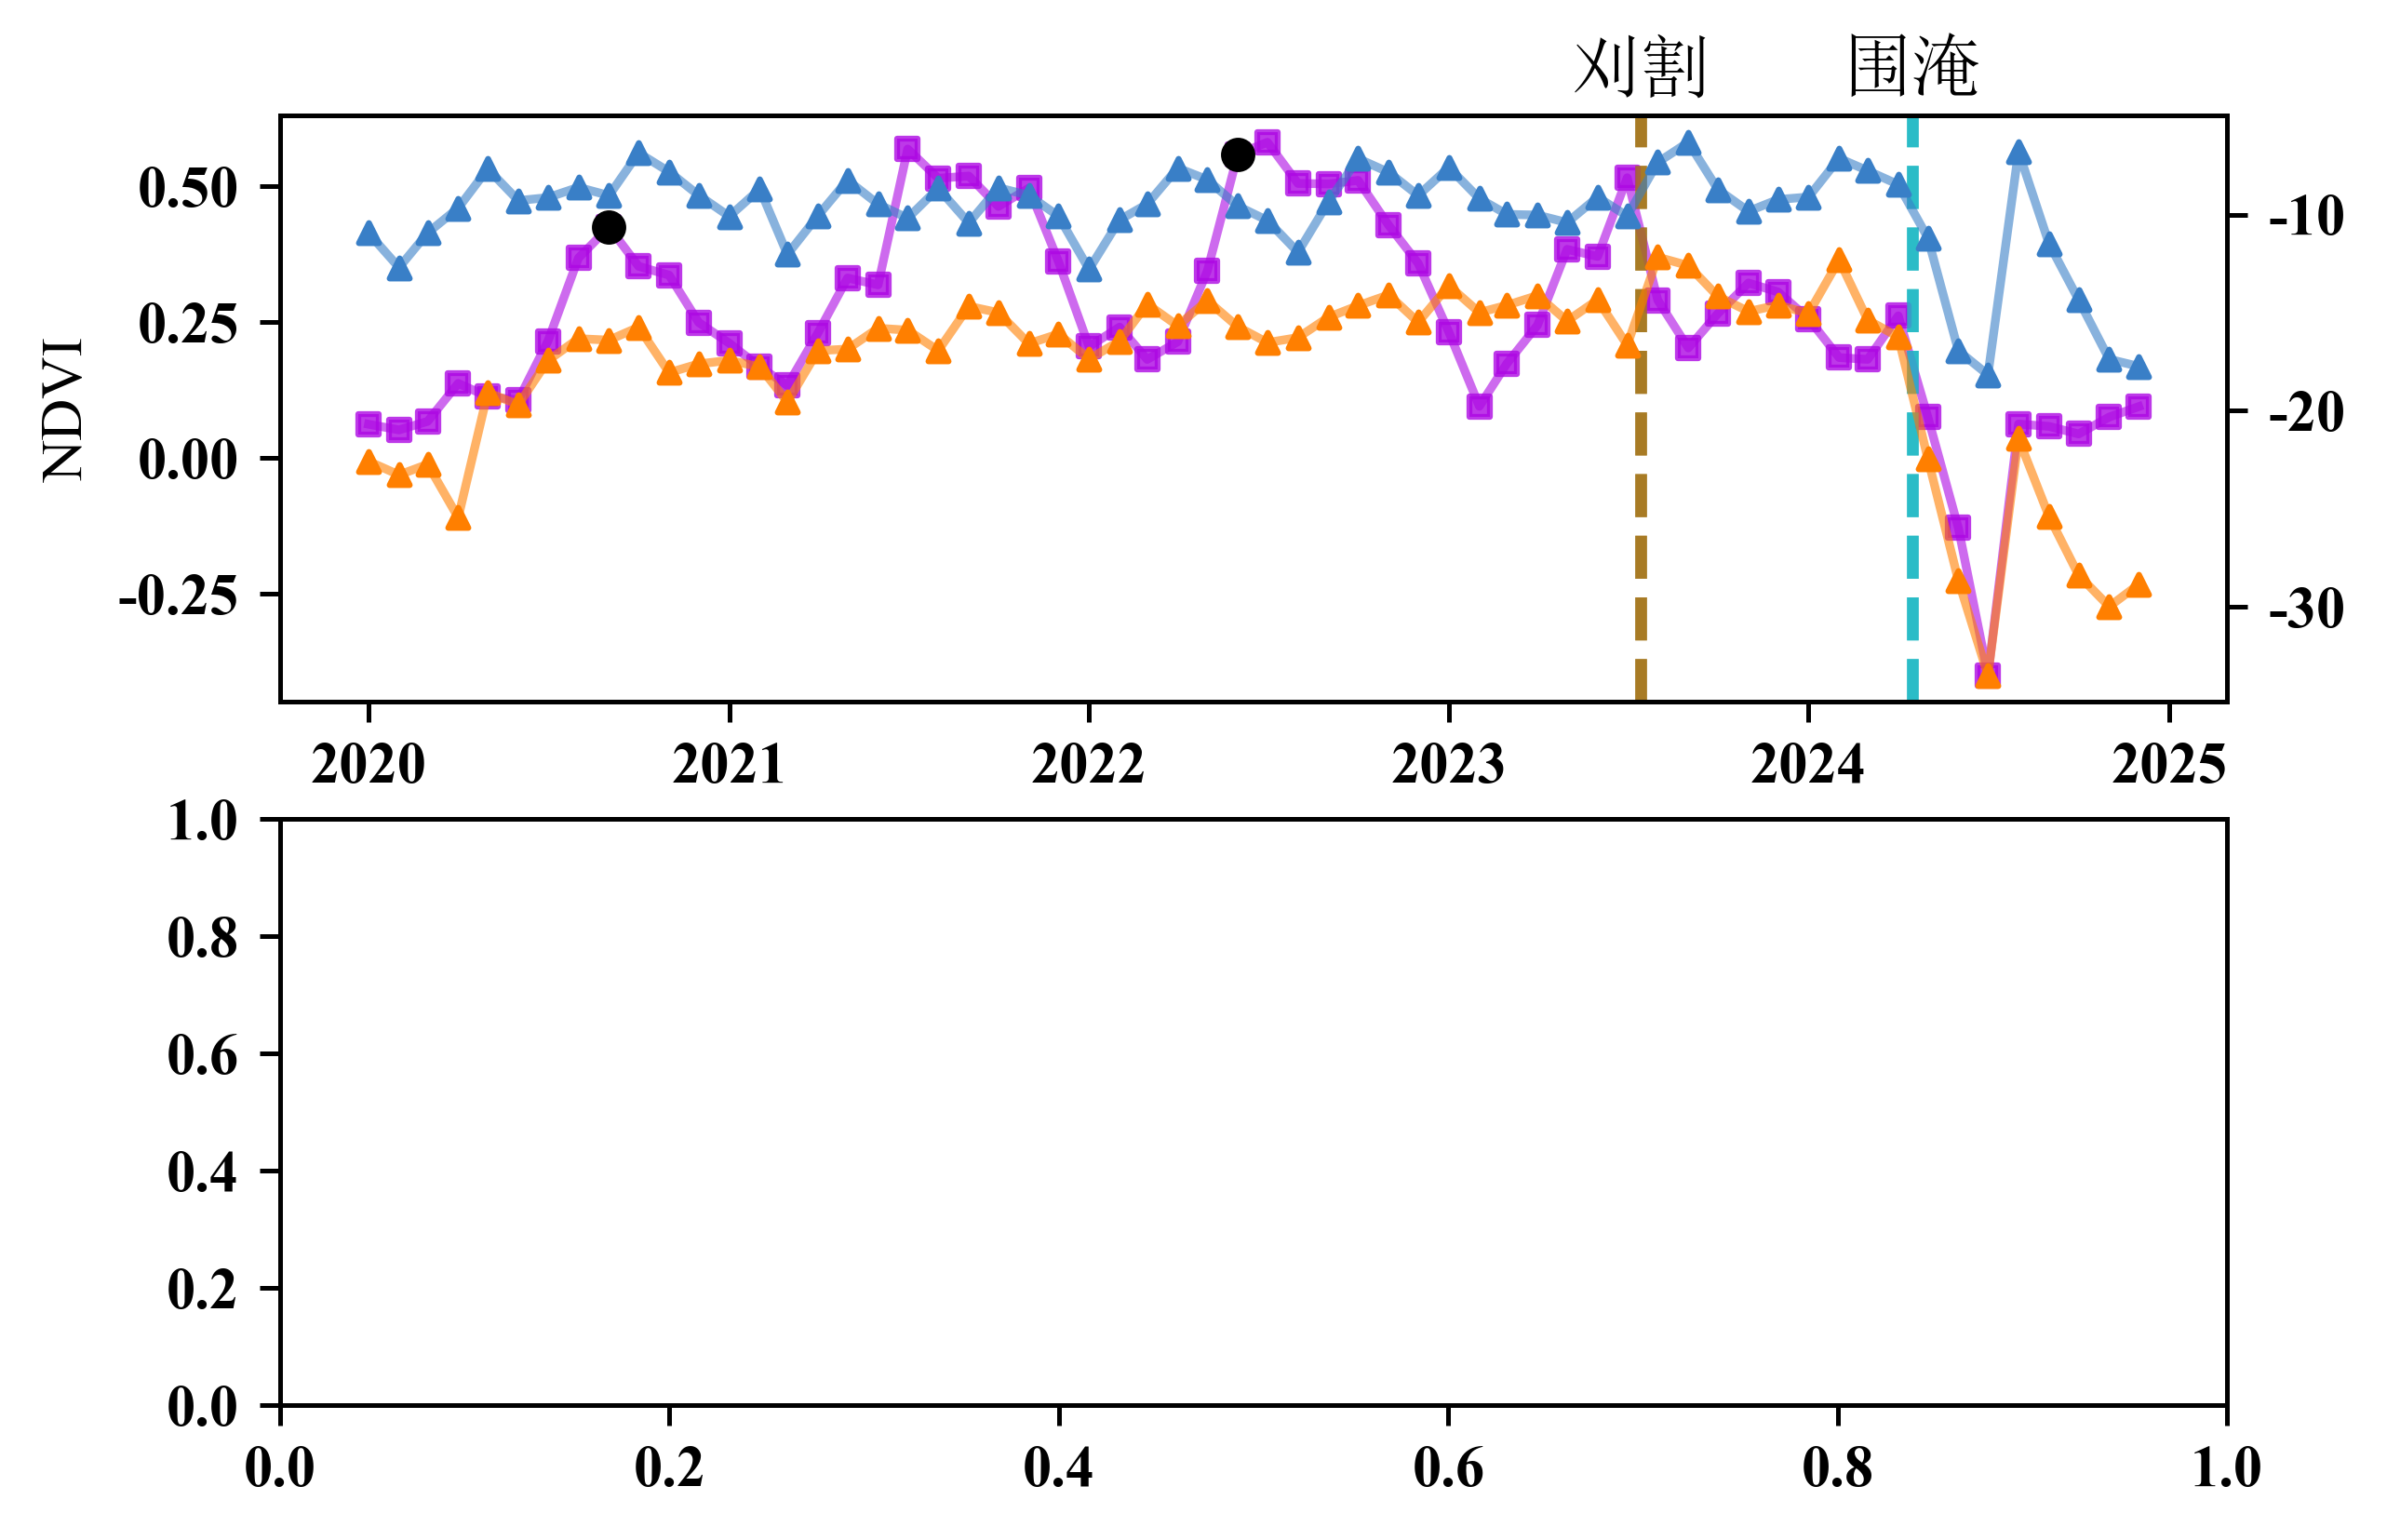

In [22]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4), dpi=450)
# ax_ndvi = ax_opt.twinx()
ax_sar = ax.twinx()
label_font_size = 10
point_size = 12
# ax_opt.set_ylabel('SR (×10⁴)', fontsize=label_font_size), ax_sar.set_ylabel('Backscatter (dB)', fontsize=label_font_size)
ax.set_ylabel('NDVI', fontsize=label_font_size)
# ax_opt.set_ylim([0, 5000]), ax_ndvi.set_ylim([-0.1, 1.2])

# NDVI
ax.scatter(dates, ndvi, s=point_size, c='#AD07E3', alpha=0.8, marker='s', zorder=99, label='_nolegend_')
ax.plot(dates, ndvi, c='#AD07E3', alpha=0.6, linewidth=1.5, linestyle='-', label='_nolegend_')

for i, e in zip(range(1, len(change_date)-1), event):
    event_color = ''
    if e == '入侵' or e == '复发':
        event_color = '#00A664'
    elif e == '围淹':
        event_color = '#23BAC5'
    elif e == '化学施药':
        event_color = '#7C7CBA'
    elif e == '刈割':
        event_color = '#A5761C'
        
    ax.axvline(x=change_date[i], color=event_color, linestyle='--', alpha=0.8, zorder=0, linewidth=2)
    ax_sar.axvline(x=change_date[i], color=event_color, linestyle='--', alpha=0.8, zorder=0, linewidth=2)
    ax.text(
        change_date[i], 
        ax.get_ylim()[1] * 1.03, e,
        ha='center', va='bottom',
        fontsize=label_font_size + 2,
        fontweight='bold',
    )
    
# SAR background
# for i in range(1, len(change_date)):
#     ax_sar.axvspan(change_date[i-1], change_date[i], facecolor=color[i-1], alpha=0.2)

for i in [dates.get_loc(pd.to_datetime(d)) for d in ['2020-09', '2022-06',]]:
    ax.scatter(dates[i], ndvi[i], s=24, c='black', alpha=1, marker='o', zorder=99, label='_nolegend_')

for values, c, sar in zip(v3h_ts.transpose(1, 0), ['#397FC7', '#FF7F00'], ['VV', 'VH']):
    ax_sar.scatter(dates, values, s=point_size, c=c, alpha=1, marker='^', label='_nolegend_')
    ax_sar.plot(dates, values, c=c, alpha=0.6, linewidth=1.5, linestyle='-', label=sar)

from matplotlib.lines import Line2D
legend_elements = []

for color, label in zip(['#AD07E3', '#E84445', '#E38D26', '#A4C97C'], ['NDVI', 'NIR', 'Red', 'Green']):
    legend_elements.append(
        Line2D([0], [0], color=color, marker='s', linestyle='-', markersize=5, linewidth=1.5, label=label)
    )
legend_elements += [
    Line2D([0], [0], color='#397FC7', marker='^', linestyle='-', 
           markersize=5, linewidth=1.5, label='VV'),
    Line2D([0], [0], color='#FF7F00', marker='^', linestyle='-', 
           markersize=5, linewidth=1.5, label='VH'),
    ]
legend_elements += [
    plt.Rectangle((0,0), 1,1, fc='#B8E5FA', alpha=1, label='Tide'),
    Line2D([0], [0], color='black', marker='o', 
           markersize=5, label='Interp'),
    ]
# for axe in (ax_opt, ax_sar):
#     axe.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
#     axe.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
#     axe.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # axe.set_xlim([dates[0], dates[-1]])
# ax_ndvi.set_yticks([-1, -0.5 ,0, 0.5, 1])
# ax_sar.legend(
#     handles=legend_elements,
#     loc='lower center',
#     bbox_to_anchor=(0.5, -0.5),
#     ncol=8,
#     frameon=False,
#     columnspacing=1.5
# )
plt.show()